# MobileNetV2 Training Notebook
## Phase 1: Initial Training (Frozen Backbone)
## Phase 2: Fine-tuning (Unfrozen Layers)


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# CELL 1: IMPORTS AND CONFIGURATION

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# Configuration
DATASET_PATH = r"D:\Datasets\skin_dataset\Skin_Conditions"
IMAGE_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 30
FINETUNING_EPOCHS = 25
INITIAL_LR = 0.001
FINETUNING_LR = 0.0001
CLASS_NAMES = ['acne', 'eczema', 'keratosis', 'carcinoma', 'milia', 'rosacea']
NUM_CLASSES = len(CLASS_NAMES)

print(f"✓ Configuration set: Image Size={IMAGE_SIZE}, Batch Size={BATCH_SIZE}, Classes={NUM_CLASSES}")

✓ All libraries imported successfully!
TensorFlow version: 2.13.0
✓ Configuration set: Image Size=224, Batch Size=32, Classes=6


# CELL 2: LOAD DATASET

In [3]:
def load_images_from_folder(dataset_path):
    """Load images and labels from folder structure"""
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            print(f"❌ ERROR: Class folder '{class_name}' not found at {class_path}")
            continue
            
        class_images = 0
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
                    img_array = keras.preprocessing.image.img_to_array(img)
                    images.append(img_array)
                    labels.append(class_idx)
                    class_images += 1
                except Exception as e:
                    print(f"⚠ Warning - Error loading {img_path}: {e}")
        
        print(f"  • {class_name}: {class_images} images loaded")
    
    return np.array(images), np.array(labels)

print("\n📂 Loading dataset...")
print(f"Dataset path: {DATASET_PATH}\n")

X, y = load_images_from_folder(DATASET_PATH)

print(f"\n✓ Dataset loaded successfully!")
print(f"  • Total images: {X.shape[0]}")
print(f"  • Image shape: {X.shape[1:]}")
print(f"  • Number of classes: {NUM_CLASSES}")
print(f"  • Class distribution: {np.bincount(y)}")


📂 Loading dataset...
Dataset path: D:\Datasets\skin_dataset\Skin_Conditions

  • acne: 399 images loaded
  • eczema: 399 images loaded
  • keratosis: 399 images loaded
  • carcinoma: 399 images loaded
  • milia: 399 images loaded
  • rosacea: 399 images loaded

✓ Dataset loaded successfully!
  • Total images: 2394
  • Image shape: (224, 224, 3)
  • Number of classes: 6
  • Class distribution: [399 399 399 399 399 399]


# CELL 3: PREPROCESSING & DATA SPLIT

In [4]:
print("\n🔄 Preprocessing data...")

# MobileNetV2 specific preprocessing: normalize to [-1, 1] range
X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
print("  ✓ Images preprocessed for MobileNetV2 (normalized to [-1, 1] range)")

# Convert labels to one-hot encoding
y_encoded = keras.utils.to_categorical(y, NUM_CLASSES)
print("  ✓ Labels converted to one-hot encoding")

# Split dataset: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

print(f"\n  ✓ Dataset split completed:")
print(f"    - Training set: {X_train.shape[0]} images ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"    - Validation set: {X_val.shape[0]} images ({X_val.shape[0]/X.shape[0]*100:.1f}%)")

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y)
class_weights = {i: X.shape[0] / (NUM_CLASSES * count) for i, count in enumerate(class_counts)}
print(f"\n  ✓ Class weights calculated (for imbalanced data handling):")
for class_name, weight in zip(CLASS_NAMES, class_weights.values()):
    print(f"    - {class_name}: {weight:.4f}")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

print(f"\n  ✓ Data augmentation configured (training set only)")
print(f"✓ Preprocessing complete!")


🔄 Preprocessing data...
  ✓ Images preprocessed for MobileNetV2 (normalized to [-1, 1] range)
  ✓ Labels converted to one-hot encoding

  ✓ Dataset split completed:
    - Training set: 1915 images (80.0%)
    - Validation set: 479 images (20.0%)

  ✓ Class weights calculated (for imbalanced data handling):
    - acne: 1.0000
    - eczema: 1.0000
    - keratosis: 1.0000
    - carcinoma: 1.0000
    - milia: 1.0000
    - rosacea: 1.0000

  ✓ Data augmentation configured (training set only)
✓ Preprocessing complete!


# CELL 4: BUILD MOBILENETV2 MODEL

In [5]:
print("\n🏗️ Building MobileNetV2 model architecture...")

# Load pretrained MobileNetV2 - ONLY the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    alpha=1.0
)

print("  ✓ MobileNetV2 base model loaded (ImageNet pretrained weights)")
print(f"  ✓ Model width multiplier (alpha): 1.0 (full model)")

# Freeze base model layers initially for Phase 1
base_model.trainable = False
print("  ✓ MobileNetV2 layers FROZEN for Phase 1")

# Build model: Input → MobileNetV2 layers → Output layer ONLY
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

print("\n  ✓ Model architecture:")
print("    INPUT (224x224x3)")
print("    ↓")
print("    MobileNetV2 (pretrained ImageNet weights)")
print("    ↓")
print("    GlobalAveragePooling2D")
print("    ↓")
print(f"    OUTPUT: Dense({NUM_CLASSES}, softmax)")

print(f"\n📝 PURE MobileNetV2 ONLY - Lightweight & Efficient Architecture")
print(f"   ~3.5M parameters vs DenseNet-121's ~8M parameters")

print(f"\n✓ Model built successfully!")
print(f"Total parameters: {model.count_params():,}")

model.summary()


🏗️ Building MobileNetV2 model architecture...
  ✓ MobileNetV2 base model loaded (ImageNet pretrained weights)
  ✓ Model width multiplier (alpha): 1.0 (full model)
  ✓ MobileNetV2 layers FROZEN for Phase 1

  ✓ Model architecture:
    INPUT (224x224x3)
    ↓
    MobileNetV2 (pretrained ImageNet weights)
    ↓
    GlobalAveragePooling2D
    ↓
    OUTPUT: Dense(6, softmax)

📝 PURE MobileNetV2 ONLY - Lightweight & Efficient Architecture
   ~3.5M parameters vs DenseNet-121's ~8M parameters

✓ Model built successfully!
Total parameters: 2,265,670
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)            

# CELL 5: PHASE 1 - INITIAL TRAINING (FROZEN BACKBONE)

In [6]:
print("\n" + "="*70)
print("PHASE 1: INITIAL TRAINING (FROZEN BACKBONE)")
print("="*70)

print("\n⚙️ Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.Precision(),
        keras.metrics.Recall()
    ]
)
print("✓ Model compiled with:")
print(f"  - Optimizer: Adam (LR={INITIAL_LR})")
print(f"  - Loss: Categorical Cross-Entropy (label_smoothing=0.1)")
print(f"  - Metrics: Accuracy, Top-3 Accuracy, Precision, Recall")

# Define callbacks - MONITORING ACCURACY
initial_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_model_phase1_mobilenet.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(f"\n📋 Callbacks configured:")
print(f"  - EarlyStopping (monitors: val_accuracy, patience=15 epochs)")
print(f"  - ReduceLROnPlateau (monitors: val_accuracy, factor=0.5, patience=5 epochs)")
print(f"  - ModelCheckpoint (monitors: val_accuracy, saves best model)")

print(f"\n🚀 Starting Phase 1 Training...")
print(f"   Epochs: {INITIAL_EPOCHS} | Batch Size: {BATCH_SIZE}")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Validation samples: {X_val.shape[0]}")

history_phase1 = model.fit(
    X_train, y_train,
    epochs=INITIAL_EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=initial_callbacks,
    verbose=1
)

print("\n✓ Phase 1 Training completed!")


PHASE 1: INITIAL TRAINING (FROZEN BACKBONE)

⚙️ Compiling model...
✓ Model compiled with:
  - Optimizer: Adam (LR=0.001)
  - Loss: Categorical Cross-Entropy (label_smoothing=0.1)
  - Metrics: Accuracy, Top-3 Accuracy, Precision, Recall

📋 Callbacks configured:
  - EarlyStopping (monitors: val_accuracy, patience=15 epochs)
  - ReduceLROnPlateau (monitors: val_accuracy, factor=0.5, patience=5 epochs)
  - ModelCheckpoint (monitors: val_accuracy, saves best model)

🚀 Starting Phase 1 Training...
   Epochs: 30 | Batch Size: 32
   Training samples: 1915
   Validation samples: 479
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 1.1952 - accuracy: 0.6245 - top_3_accuracy: 0.8809 - precision: 0.8147 - recall: 0.4272
Epoch 1: val_accuracy improved from -inf to 0.77453, saving model to best_model_phase1_mobilenet.h5
60/60 [==============================] - 26s 405ms/step - loss: 1.1952 - accuracy: 0.6245 - top_3_accuracy: 0.8809 - precision: 0.8147 - recall: 0.4272 - val_loss

# CELL 6: PHASE 2 - FINE-TUNING (PARTIAL UNFREEZING)

In [7]:
print("\n" + "="*70)
print("PHASE 2: FINE-TUNING (PARTIAL UNFREEZING)")
print("="*70)

print("\n🔓 Unfreezing last 30 layers of MobileNetV2...")

# Unfreeze last 30 layers (MobileNetV2 has fewer layers than DenseNet-121)
unfrozen_count = 0
for layer in base_model.layers[-30:]:
    layer.trainable = True
    unfrozen_count += 1

print(f"✓ {unfrozen_count} layers unfrozen for fine-tuning")

# Recompile with lower learning rate
print("\n⚙️ Recompiling model with lower learning rate...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINETUNING_LR),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.Precision(),
        keras.metrics.Recall()
    ]
)

print("✓ Model recompiled with:")
print(f"  - Optimizer: Adam (LR={FINETUNING_LR})")
print(f"  - Loss: Categorical Cross-Entropy (label_smoothing=0.1)")
print(f"  - Metrics: Accuracy, Top-3 Accuracy, Precision, Recall")

# Fine-tuning callbacks - MONITORING ACCURACY
finetuning_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_model_phase2_mobilenet.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(f"\n📋 Callbacks configured:")
print(f"  - EarlyStopping (monitors: val_accuracy, patience=12 epochs)")
print(f"  - ReduceLROnPlateau (monitors: val_accuracy, factor=0.5, patience=4 epochs)")
print(f"  - ModelCheckpoint (monitors: val_accuracy, saves best model)")

print(f"\n🚀 Starting Phase 2 Fine-Tuning...")
print(f"   Epochs: {FINETUNING_EPOCHS} | Batch Size: {BATCH_SIZE}")

history_phase2 = model.fit(
    X_train, y_train,
    epochs=FINETUNING_EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=finetuning_callbacks,
    verbose=1
)

print("\n✓ Phase 2 Fine-Tuning completed!")


PHASE 2: FINE-TUNING (PARTIAL UNFREEZING)

🔓 Unfreezing last 30 layers of MobileNetV2...
✓ 30 layers unfrozen for fine-tuning

⚙️ Recompiling model with lower learning rate...
✓ Model recompiled with:
  - Optimizer: Adam (LR=0.0001)
  - Loss: Categorical Cross-Entropy (label_smoothing=0.1)
  - Metrics: Accuracy, Top-3 Accuracy, Precision, Recall

📋 Callbacks configured:
  - EarlyStopping (monitors: val_accuracy, patience=12 epochs)
  - ReduceLROnPlateau (monitors: val_accuracy, factor=0.5, patience=4 epochs)
  - ModelCheckpoint (monitors: val_accuracy, saves best model)

🚀 Starting Phase 2 Fine-Tuning...
   Epochs: 25 | Batch Size: 32
Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 1.2097 - accuracy: 0.6230 - top_3_accuracy: 0.8956 - precision_1: 0.7722 - recall_1: 0.4585
Epoch 1: val_accuracy improved from -inf to 0.81420, saving model to best_model_phase2_mobilenet.h5
60/60 [==============================] - 39s 615ms/step - loss: 1.2097 - accuracy: 0.6230 - top_

# CELL 7: MODEL EVALUATION & METRICS

In [8]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

print("\n📊 Evaluating model on validation set...")

val_results = model.evaluate(X_val, y_val, verbose=0)
val_loss = val_results[0]
val_accuracy = val_results[1]
val_top3 = val_results[2]
val_precision = val_results[3]
val_recall = val_results[4]

print(f"\n✓ Validation Results:")
print(f"  - Loss: {val_loss:.4f}")
print(f"  - Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  - Top-3 Accuracy: {val_top3:.4f} ({val_top3*100:.2f}%)")
print(f"  - Precision: {val_precision:.4f}")
print(f"  - Recall: {val_recall:.4f}")

# Calculate F1-score
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"  - F1-Score: {f1_score:.4f}")

# Save final model
print("\n💾 Saving final model...")
model.save('final_mobilenetv2_model.h5')
print("✓ Final model saved as 'final_mobilenetv2_model.h5'")


MODEL EVALUATION

📊 Evaluating model on validation set...

✓ Validation Results:
  - Loss: 0.7732
  - Accuracy: 0.8727 (87.27%)
  - Top-3 Accuracy: 0.9770 (97.70%)
  - Precision: 0.9227
  - Recall: 0.8225
  - F1-Score: 0.8698

💾 Saving final model...
✓ Final model saved as 'final_mobilenetv2_model.h5'


# CELL 8: CONFUSION MATRIX & CLASSIFICATION REPORT


CONFUSION MATRIX & CLASSIFICATION REPORT

🔍 Generating predictions on validation set...

✓ Confusion Matrix:
[[62  1  0  3  4  9]
 [10 61  0  1  3  5]
 [ 0  1 76  2  0  1]
 [ 2  1  0 77  0  0]
 [ 2  3  1  2 71  1]
 [ 7  1  0  1  0 71]]

✓ Classification Report:
              precision    recall  f1-score   support

        acne       0.75      0.78      0.77        79
      eczema       0.90      0.76      0.82        80
   keratosis       0.99      0.95      0.97        80
   carcinoma       0.90      0.96      0.93        80
       milia       0.91      0.89      0.90        80
     rosacea       0.82      0.89      0.85        80

    accuracy                           0.87       479
   macro avg       0.88      0.87      0.87       479
weighted avg       0.88      0.87      0.87       479


📈 Plotting confusion matrix...
✓ Confusion matrix saved as 'confusion_matrix_mobilenet.png'


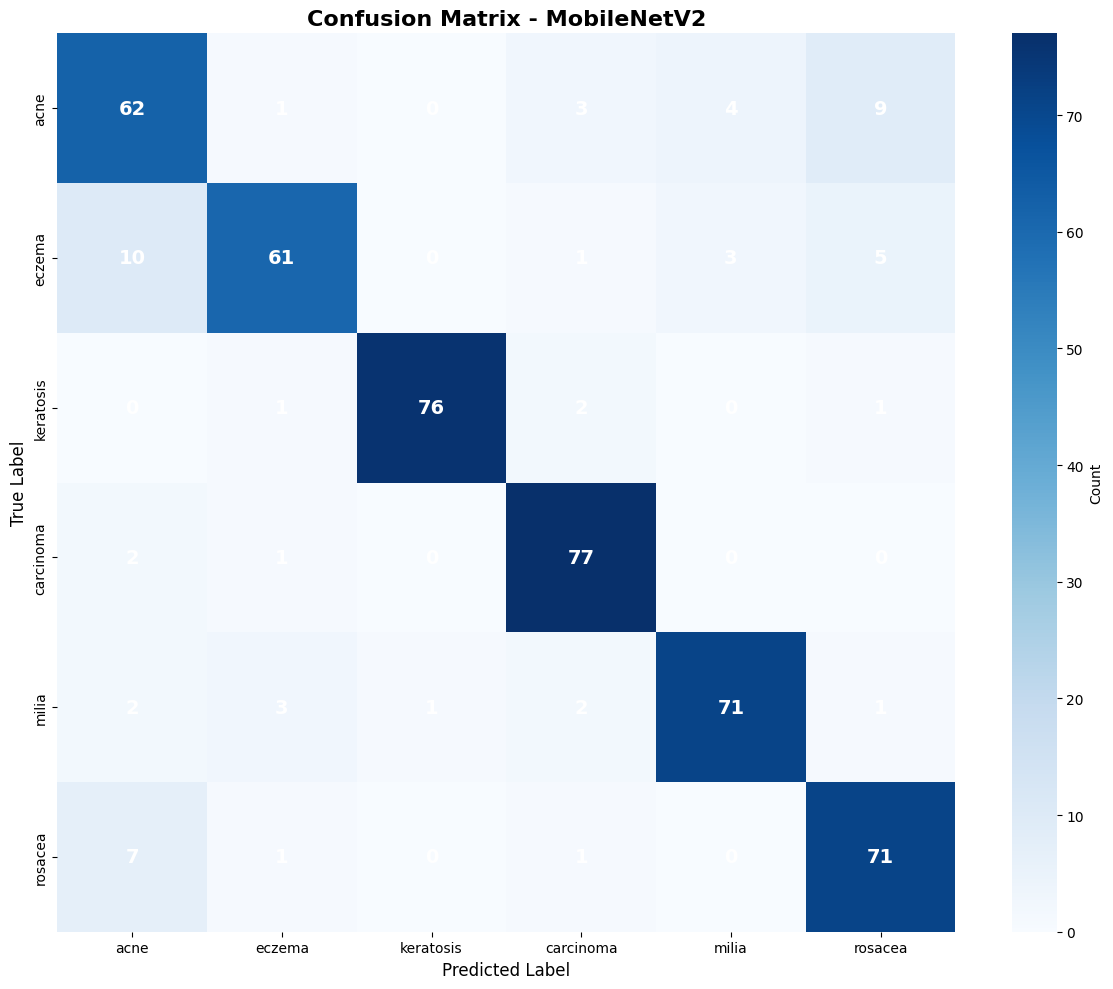


✅ ALL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!

📱 MobileNetV2 Benefits:
  • Lightweight: ~3.5M parameters (60% fewer than DenseNet-121)
  • Fast inference: Optimized for mobile/edge devices
  • Lower memory footprint
  • Excellent accuracy-to-size ratio


In [9]:
print("\n" + "="*70)
print("CONFUSION MATRIX & CLASSIFICATION REPORT")
print("="*70)

print("\n🔍 Generating predictions on validation set...")

y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)
print("\n✓ Confusion Matrix:")
print(cm)

# Classification Report
print("\n✓ Classification Report:")
report = classification_report(y_val_classes, y_pred_classes, target_names=CLASS_NAMES)
print(report)

# Plot Confusion Matrix with CLEAR NUMBERS
print("\n📈 Plotting confusion matrix...")
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'color': 'white', 'weight': 'bold'})
plt.title('Confusion Matrix - MobileNetV2', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_mobilenet.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix_mobilenet.png'")
plt.show()

print("\n" + "="*70)
print("✅ ALL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📱 MobileNetV2 Benefits:")
print("  • Lightweight: ~3.5M parameters (60% fewer than DenseNet-121)")
print("  • Fast inference: Optimized for mobile/edge devices")
print("  • Lower memory footprint")
print("  • Excellent accuracy-to-size ratio")